## `operator_report` work

In [1]:
import altair as alt
import calitp_data_analysis.magics
import geopandas as gpd
import google.auth
import merge_data
import pandas as pd
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from shared_utils import portfolio_utils, publish_utils, rt_dates
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

readable_dict = OmegaConf.load("readable2.yml")
credentials, project = google.auth.default()

import _report_operator_visuals
import _report_route_dir_visuals
import _scheduled_service_hour_visuals

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)


def formatted(number):
    return "{:,}".format(number)

In [3]:
portfolio_name = "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"

In [21]:
ROUTE_DIR_MONTH_FILE = GTFS_DATA_DICT.digest_tables.monthly_route_schedule_vp_report
# ROUTE_DIR_MONTH_FILE = GTFS_DATA_DICT.digest_tables.monthly_route_schedule_vp 
OPERATOR_PROFILES = GTFS_DATA_DICT.digest_tables.operator_profiles_report
OPERATOR_ROUTE_MAP = GTFS_DATA_DICT.digest_tables.operator_routes_map_report
SCHEDULED_SERVICES = f"{GTFS_DATA_DICT.digest_tables.scheduled_service_hours}_report"
ROUTE_DIR_QTR_FILE = "digest/quarterly_schedule_vp_metrics_report"

route_dir_month_df = pd.read_parquet(
    f"{RT_SCHED_GCS}{ROUTE_DIR_MONTH_FILE}.parquet",
    filters=[[("Portfolio Organization Name", "==", portfolio_name)]],
)
""" 
route_dir_month_df = pd.read_parquet(
    f"{RT_SCHED_GCS}{ROUTE_DIR_MONTH_FILE}.parquet",
    filters=[[("portfolio_organization_name", "==", portfolio_name)]],
)
"""
route_dir_qtr_df = pd.read_parquet(
    f"{RT_SCHED_GCS}{ROUTE_DIR_QTR_FILE}.parquet",
    filters=[[("Portfolio Organization Name", "==", portfolio_name)]],
)

route_df = gpd.read_parquet(
    f"{RT_SCHED_GCS}{OPERATOR_ROUTE_MAP}.parquet",
    filters=[[("portfolio_organization_name", "==", portfolio_name)]],
    storage_options={"token": credentials.token},
)

profile_df = pd.read_parquet(
    f"{RT_SCHED_GCS}{OPERATOR_PROFILES}.parquet",
    filters=[[("portfolio_organization_name", "==", portfolio_name)]],
)

In [5]:
route_dir_qtr_df.shape

(2113, 23)

### Observation 1: Route Names are a repeated after removing them from `rt_segment_speeds/segment_speed_utils/time_series_utils` for VCTC
* If I can find an easy way to delete out the exact 2 strings, then I can do it.
* Otherwise, it's ok to leave it like this because this is a trade off between grouping names vs combining them. 
* Test just for one route for VCTC and see where the number of rows increases. 
* 

In [6]:
# route_dir_month_df["Route"].unique()

### Observation 2: the titles of the two text tables don't change even when the routes are changed. 

In [7]:
route_dir_month_df.sample(1)

,Direction (0/1),Period,Average Scheduled Service (trip minutes),# Scheduled Trips,# Realtime Trips,Route,Direction,# Minutes with 1+ VP per Minute,# Minutes with 2+ VP per Minute,# Early Arrival Trips,# On-Time Trips,# Late Trips,Average VP per Minute,% VP within Scheduled Shape,% Scheduled Trip w/ 1+ VP/Minute,% Scheduled Trip w/ 2+ VP/Minute,Realtime versus Scheduled Service Ratio,Speed (MPH),Portfolio Organization Name,Headway (Minutes),GTFS Availability,Average Stop Distance (Miles),Date
2933,1,Offpeak,119.00,2,2,55X 55 Conejo Connection,Eastbound,153,152,1,0,1,3.00,100.00,100.00,100.00,1.00,30.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",500.00,schedule_and_vp,4.00,2024-02-14


In [8]:
route_dir_month_df.loc[route_dir_month_df.Route == "Route 1 Route 1"].Direction.unique()

array(['Southbound', 'Northbound'], dtype=object)

In [9]:
route_dir_month_df.loc[route_dir_month_df.Route == "Route 8 Route 8"].Direction.unique()

array(['Southbound', 'Northbound'], dtype=object)

### Observation #3: Duplicated values somewhere in the pipline?
* Coming from one of the merges. 
* Go back to `merge_data` and breakout where it is.
* This looks 

In [10]:
route_86_coastal = route_dir_month_df.loc[
    (
        route_dir_month_df.Date.isin(
            [
                "2025-01-15T00:00:00.000000000",
                "2025-02-12T00:00:00.000000000",
                "2025-03-12T00:00:00.000000000",
            ]
        )
    )
    & (route_dir_month_df.Route == "86 80-89 Coastal Express")
]

In [11]:
route_86_coastal.columns

Index(['Direction (0/1)', 'Period', 'Average Scheduled Service (trip minutes)',
       '# Scheduled Trips', '# Realtime Trips', 'Route', 'Direction',
       '# Minutes with 1+ VP per Minute', '# Minutes with 2+ VP per Minute',
       '# Early Arrival Trips', '# On-Time Trips', '# Late Trips',
       'Average VP per Minute', '% VP within Scheduled Shape',
       '% Scheduled Trip w/ 1+ VP/Minute', '% Scheduled Trip w/ 2+ VP/Minute',
       'Realtime versus Scheduled Service Ratio', 'Speed (MPH)',
       'Portfolio Organization Name', 'Headway (Minutes)', 'GTFS Availability',
       'Average Stop Distance (Miles)', 'Date'],
      dtype='object')

In [12]:
route_86_coastal.head(5)

,Direction (0/1),Period,Average Scheduled Service (trip minutes),# Scheduled Trips,# Realtime Trips,Route,Direction,# Minutes with 1+ VP per Minute,# Minutes with 2+ VP per Minute,# Early Arrival Trips,# On-Time Trips,# Late Trips,Average VP per Minute,% VP within Scheduled Shape,% Scheduled Trip w/ 1+ VP/Minute,% Scheduled Trip w/ 2+ VP/Minute,Realtime versus Scheduled Service Ratio,Speed (MPH),Portfolio Organization Name,Headway (Minutes),GTFS Availability,Average Stop Distance (Miles),Date
4428,0,All Day,112.00,2,2,86 80-89 Coastal Express,Westbound,201,196,1,0,1,1.00,0.00,100.00,100.00,3.00,42.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",750.00,schedule_and_vp,3.00,2025-01-15
4429,0,All Day,112.00,2,2,86 80-89 Coastal Express,Westbound,201,200,1,0,1,1.00,0.00,100.00,100.00,3.00,40.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",750.00,schedule_and_vp,57.00,2025-02-12
4430,0,All Day,112.00,2,2,86 80-89 Coastal Express,Westbound,121,117,1,0,1,2.00,100.00,100.00,100.00,1.00,38.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",750.00,schedule_and_vp,57.00,2025-03-12
4453,0,Offpeak,112.00,2,2,86 80-89 Coastal Express,Westbound,201,196,1,0,1,1.00,0.00,100.00,100.00,3.00,42.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",500.00,schedule_and_vp,3.00,2025-01-15
4454,0,Offpeak,112.00,2,2,86 80-89 Coastal Express,Westbound,201,200,1,0,1,1.00,0.00,100.00,100.00,3.00,40.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",500.00,schedule_and_vp,57.00,2025-02-12


In [13]:
len(route_86_coastal)

12

In [14]:
len(route_86_coastal.drop_duplicates())

12

In [15]:
route_86_coastal.columns

Index(['Direction (0/1)', 'Period', 'Average Scheduled Service (trip minutes)',
       '# Scheduled Trips', '# Realtime Trips', 'Route', 'Direction',
       '# Minutes with 1+ VP per Minute', '# Minutes with 2+ VP per Minute',
       '# Early Arrival Trips', '# On-Time Trips', '# Late Trips',
       'Average VP per Minute', '% VP within Scheduled Shape',
       '% Scheduled Trip w/ 1+ VP/Minute', '% Scheduled Trip w/ 2+ VP/Minute',
       'Realtime versus Scheduled Service Ratio', 'Speed (MPH)',
       'Portfolio Organization Name', 'Headway (Minutes)', 'GTFS Availability',
       'Average Stop Distance (Miles)', 'Date'],
      dtype='object')

In [17]:
ROUTE_DIR_QTR_EXPORT = GTFS_DATA_DICT.digest_tables.quarterly_route_schedule_vp_report

In [18]:
route_dir_qtr_df = pd.read_parquet(f"{RT_SCHED_GCS}{ROUTE_DIR_QTR_EXPORT}.parquet")

In [19]:
route_dir_qtr_df.loc[
    (route_dir_qtr_df.Route == "86 80-89 Coastal Express")
    & (route_dir_qtr_df.Quarter == "2025 Q1")
]

,Direction (0/1),Period,Average Scheduled Service (trip minutes),# Scheduled Trips,# Realtime Trips,Route,Direction,# Minutes with 1+ VP per Minute,# Minutes with 2+ VP per Minute,# Early Arrival Trips,# On-Time Trips,# Late Trips,Average VP per Minute,% VP within Scheduled Shape,% Scheduled Trip w/ 1+ VP/Minute,% Scheduled Trip w/ 2+ VP/Minute,Realtime versus Scheduled Service Ratio,Speed (MPH),Portfolio Organization Name,Headway (Minutes),GTFS Availability,Average Stop Distance (Miles),Quarter
97640,0,All Day,112.00,6,6,86 80-89 Coastal Express,Westbound,174.00,171.00,3,0,3,1.00,0.00,100.00,100.00,2.00,40.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",750.00,schedule_and_vp,39.00,2025 Q1
97698,0,Offpeak,112.00,6,6,86 80-89 Coastal Express,Westbound,174.00,171.00,3,0,3,1.00,0.00,100.00,100.00,2.00,40.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",500.00,schedule_and_vp,39.00,2025 Q1
97793,1,All Day,106.00,6,6,86 80-89 Coastal Express,Eastbound,357.00,351.00,0,0,6,1.00,0.00,200.00,200.00,4.00,11.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",750.00,schedule_and_vp,3.00,2025 Q1
97862,1,Peak,106.00,6,6,86 80-89 Coastal Express,Eastbound,357.00,351.00,0,0,6,1.00,0.00,200.00,200.00,4.00,11.00,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",240.00,schedule_and_vp,3.00,2025 Q1


In [20]:
route_dir_qtr_df.loc[
    (route_dir_qtr_df.Route == "86 80-89 Coastal Express")
    & (route_dir_qtr_df.Quarter == "2025 Q1")
].shape

(4, 23)

### Go back to `merge_data` and figure out why there are so many rows.

In [40]:
analysis_date_list = rt_dates.y2025_dates

In [41]:
analysis_date_list

['2025-01-15', '2025-02-12', '2025-03-12', '2025-04-16', '2025-05-14']

In [ ]:
one_route = "86 80-89 Coastal Express"

#### df_sched looks fine

In [ ]:
df_sched = merge_data.concatenate_schedule_by_route_direction(analysis_date_list)

In [ ]:
df_sched = df_sched.loc[(df_sched.recent_combined_name == one_route)]

In [ ]:
df_sched.shape

In [ ]:
len(df_sched), len(df_sched.drop_duplicates())

In [ ]:
df_sched.service_date.value_counts()

In [ ]:
df_sched.time_period.value_counts()

In [ ]:
df_sched.schedule_gtfs_dataset_key.unique()

In [ ]:
# df_sched

#### df_speeds

In [ ]:
df_avg_speeds = merge_data.concatenate_speeds_by_route_direction(analysis_date_list)

In [ ]:
df_avg_speeds.columns

In [ ]:
df_avg_speeds = df_avg_speeds.loc[
    (df_avg_speeds.route_id == "4145")
    & (df_avg_speeds.schedule_gtfs_dataset_key == "1770249a5a2e770ca90628434d4934b1")
]

In [ ]:
df_avg_speeds

#### df_rt_sched has a lot of duplicated rows

In [ ]:
df_rt_sched = merge_data.concatenate_rt_vs_schedule_by_route_direction(
    analysis_date_list
)

In [ ]:
df_rt_sched.columns

In [ ]:
df_rt_sched = df_rt_sched.loc[
    (df_rt_sched.route_id == "4145")
    & (df_rt_sched.schedule_gtfs_dataset_key == "1770249a5a2e770ca90628434d4934b1")
]

In [ ]:
len(df_rt_sched), len(df_rt_sched.drop_duplicates())

In [ ]:
df_rt_sched[['service_date', 'direction_id', 'time_period',
       'minutes_atleast1_vp', 'minutes_atleast2_vp',
       'total_rt_service_minutes', 'total_scheduled_service_minutes',
       'total_vp', 'vp_in_shape', 'is_early', 'is_ontime', 'is_late',
       'n_vp_trips', 'vp_per_minute', 'pct_in_shape',
       'pct_rt_journey_atleast1_vp', 'pct_rt_journey_atleast2_vp',
       'pct_sched_journey_atleast1_vp', 'pct_sched_journey_atleast2_vp',
       'rt_sched_journey_ratio', 'avg_rt_service_minutes', ]]

### This chart is a little hard to read, change to grouped bar
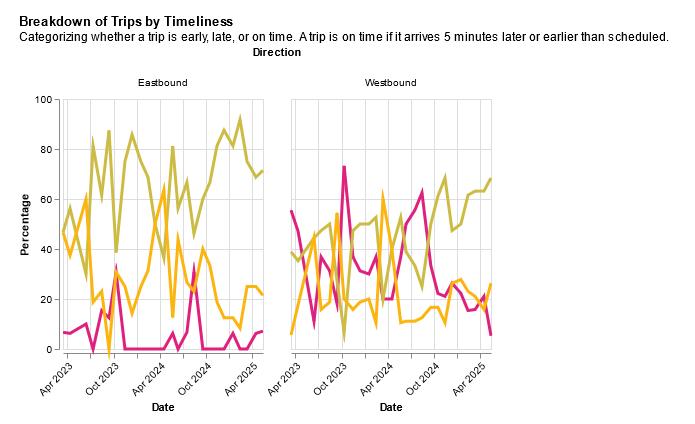

In [22]:
import _report_route_dir_visuals

In [24]:
df2 = _report_route_dir_visuals.reshape_timeliness_trips(route_dir_month_df)

In [26]:
df2 = df2.loc[
    (df2.Route == "86 80-89 Coastal Express")
]

In [27]:
df2.shape

(294, 10)

In [28]:
df2.columns

Index(['Date', 'Portfolio Organization Name', 'Route', 'Period', 'Direction',
       'Direction (0/1)', '# Realtime Trips', 'variable', 'value',
       'Percentage'],
      dtype='object')

In [36]:
df2.Period.unique()

array(['All Day', 'Offpeak', 'Peak'], dtype=object)

In [29]:
df2.head()

,Date,Portfolio Organization Name,Route,Period,Direction,Direction (0/1),# Realtime Trips,variable,value,Percentage
4408,2023-04-12,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",86 80-89 Coastal Express,All Day,Westbound,0,2,# Early Arrival Trips,0,0.00
4409,2023-06-14,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",86 80-89 Coastal Express,All Day,Westbound,0,2,# Early Arrival Trips,0,0.00
4410,2023-07-12,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",86 80-89 Coastal Express,All Day,Westbound,0,2,# Early Arrival Trips,0,0.00
4411,2023-08-15,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",86 80-89 Coastal Express,All Day,Westbound,0,2,# Early Arrival Trips,1,50.00
4412,2023-09-13,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",86 80-89 Coastal Express,All Day,Westbound,0,1,# Early Arrival Trips,0,0.00


In [25]:
specific_chart_dict = readable_dict.timeliness_trips_graph

In [35]:
_report_route_dir_visuals.grouped_bar_chart(
        df2,
        x_col = "Date",
        y_col="Percentage",
        color_col="variable",
        color_scheme = [*specific_chart_dict.colors],
        tooltip_cols = [*specific_chart_dict.tooltip],
        date_format = "",
        offset_col="variable:N",
    ).facet(
        column=alt.Column(
            "Period:N",
        )

alt.Chart(...)